Personal Loan Classification Task

As a lender, one of the core business challenges that Avant faces is predicting each potential borrower’s chance of default if Avant were to approve their loan application. In this data challenge, Avant’s Data Science team has prepared a small dataset that mimics the default prediction challenge that we try to solve and improve upon every day. The goal is to predict 
whether a borrower is going to default by learning from the pool of borrowers’ behavior. 



# Table of Contents 

1. [Load Dataset and Python Packages](#section1)

2. [Define Dependent Variable](#section2)

3. [Data Quality Assessment](#section3)

4. [Exploratory Data Analysis and Feature Selection](#section4)

    4.1 [Exploration on variable 'term'](#section4.1)
    
    4.2 [Exploration on variable 'emp_length'](#section4.2)
    
    4.3 [Exploration on variable 'home_ownership'](#section4.3)
    
    4.4 [Exploration on variable 'verification_status'](#section4.4)
    
    4.5 [Exploration on variable 'purpose'](#section4.5)
    
    4.6 [Exploration on variable 'addr_state'](#section4.6)
    
    4.7 [Exploration on variable 'issue_time' and 'earliest_time'](#section4.7)
    
    4.8 [Exploration on variable 'fico_range_low' and 'fico_range_high'](#section4.8)
    
    4.9 [Exploration on variable 'mths_since_last_delinq'](#section4.9)
    
    4.10 [Exploration on variable 'inq_last_12m'](#section4.10)
    
    4.11 [Miscellaneous](#section4.11)
    
5. [Model Building](#section5)
    
    5.1 [Logistic Regression](#section5.1)
    
    5.2 [Gradient Boosting](#section5.2)
    
    5.3 [Random Forest](#section5.3)
    
6. [Hypothesis Testing and Conclusion](#section6)

7. [Future Work](#section7)


<a id='section1'></a>

1.Load Dataset and Python Packages

In [78]:
# import python package
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
import seaborn as sns; sns.set_style("whitegrid")

In [10]:
data = pd.read_csv('data.csv')
data.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,last_credit_pull_d,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
0,88787390,30000,60 months,761.64,6 years,RENT,100100.0,Verified,Sep-2016,Current,...,Dec-2016,709,705,0,0,0,26.0,NaN,0,0.0
1,74722660,30000,60 months,692.93,10+ years,MORTGAGE,235000.0,Source Verified,Apr-2016,Current,...,Dec-2016,649,645,0,0,1,16.0,NaN,1,3.0
2,67919555,16000,60 months,379.39,6 years,RENT,84000.0,Not Verified,Jan-2016,Current,...,Dec-2016,739,735,0,0,0,80.0,NaN,0,2.0
3,54027458,14000,36 months,439.88,5 years,RENT,50000.0,Source Verified,Jul-2015,Fully Paid,...,Oct-2016,749,745,0,0,0,NaN,42.0,0,NaN
4,72594974,7500,36 months,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-2016,Fully Paid,...,Dec-2016,709,705,0,0,0,NaN,NaN,2,5.0


<a id='section2'></a>

2.Find Dependent Variable

Since the goal is to predict whether a borrower is going to default by learning from the pool of borrowers’ behavior, I choose loan_status as the dependent variable.
There are three categories of this variable: Current, Fully Paid and Default.
Current: The borrower has paid off all due payments as of the latest due date.
Fully Paid: The borrower has paid off the entire balance of the loan. 
Default: The borrower has not paid off all due payments as of the latest due date.
So I constructed a binary variable called default_status to replace loan_status, used 0 to represent the Default, and 1 to represent Current and Fully Paid, which can be seen as not default. 


In [11]:
# create a new variable default_status to be the dependent variable
# let current and fully paid to be non-default
def default_or_not(row):
   
    loan_status = row['loan_status']


    if loan_status == "Default":
        default_status = 0
    else:
        default_status = 1 

    return pd.Series({'default_status':default_status})

In [12]:
response = data.apply(default_or_not, axis=1)

data = data.join(response)# merget together

data.drop('loan_status', axis=1, inplace=True)

data.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m,default_status
0,88787390,30000,60 months,761.64,6 years,RENT,100100.0,Verified,Sep-2016,debt_consolidation,...,709,705,0,0,0,26.0,NaN,0,0.0,1
1,74722660,30000,60 months,692.93,10+ years,MORTGAGE,235000.0,Source Verified,Apr-2016,home_improvement,...,649,645,0,0,1,16.0,NaN,1,3.0,1
2,67919555,16000,60 months,379.39,6 years,RENT,84000.0,Not Verified,Jan-2016,debt_consolidation,...,739,735,0,0,0,80.0,NaN,0,2.0,1
3,54027458,14000,36 months,439.88,5 years,RENT,50000.0,Source Verified,Jul-2015,debt_consolidation,...,749,745,0,0,0,NaN,42.0,0,NaN,1
4,72594974,7500,36 months,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-2016,debt_consolidation,...,709,705,0,0,0,NaN,NaN,2,5.0,1


C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


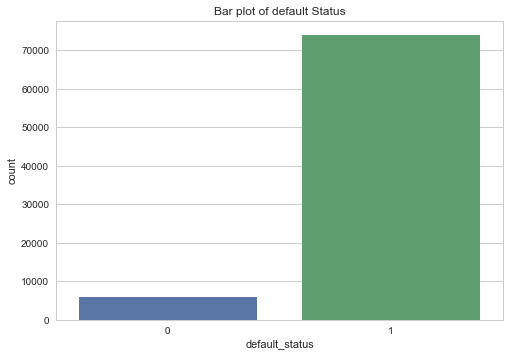

Percentage of Default Status: 


1    92.45375
0     7.54625
Name: default_status, dtype: float64

In [13]:
# 0 represents default
sns.countplot(x="default_status", data=data)
plt.title("Bar plot of default Status")
plt.show()
print("Percentage of Default Status: ")
100 * data['default_status'].value_counts()/len(data)

<a id='section3'></a>

3.Data Quality Assessment

To check for missing value, variable type and duplicate ID.

In [14]:
# displace data volumn and types 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 26 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null object
installment               80000 non-null float64
emp_length                75131 non-null object
home_ownership            80000 non-null object
annual_inc                80000 non-null float64
verification_status       80000 non-null object
issue_d                   80000 non-null object
purpose                   80000 non-null object
addr_state                80000 non-null object
dti                       80000 non-null float64
earliest_cr_line          80000 non-null object
fico_range_low            80000 non-null int64
fico_range_high           80000 non-null int64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            8000

In [15]:
# check if data set contains duplicated appointment ID
print(data.id.duplicated().sum())

0


In [16]:
# check if data set contains missing values
print(data.isnull().sum())

id                            0
loan_amnt                     0
term                          0
installment                   0
emp_length                 4869
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
purpose                       0
addr_state                    0
dti                           0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
last_credit_pull_d            4
last_fico_range_high          0
last_fico_range_low           0
acc_now_delinq                0
delinq_amnt                   0
delinq_2yrs                   0
mths_since_last_delinq    38214
mths_since_last_record    65468
inq_last_6mths                0
inq_last_12m              42605
default_status                0
dtype: int64


<a id='section4'></a>

4.Exploratory Data Analysis and Feature Selection

<a id='section4.1'></a>

4.1 Exploration on the variable 'term'

The attribute ‘term’ only has two values: 60 months and 36 months.
So I convert the value 60 month into 1 and 36 month into 0, to make it a binary variable.


In [17]:
# transform term into 1, 0 variable
data.term = data.term.astype('category').cat.rename_categories(['0', '1'])
data.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m,default_status
0,88787390,30000,1,761.64,6 years,RENT,100100.0,Verified,Sep-2016,debt_consolidation,...,709,705,0,0,0,26.0,NaN,0,0.0,1
1,74722660,30000,1,692.93,10+ years,MORTGAGE,235000.0,Source Verified,Apr-2016,home_improvement,...,649,645,0,0,1,16.0,NaN,1,3.0,1
2,67919555,16000,1,379.39,6 years,RENT,84000.0,Not Verified,Jan-2016,debt_consolidation,...,739,735,0,0,0,80.0,NaN,0,2.0,1
3,54027458,14000,0,439.88,5 years,RENT,50000.0,Source Verified,Jul-2015,debt_consolidation,...,749,745,0,0,0,NaN,42.0,0,NaN,1
4,72594974,7500,0,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-2016,debt_consolidation,...,709,705,0,0,0,NaN,NaN,2,5.0,1


<a id='section4.2'></a>

4.2 Exploration on the variable 'emp_length'

For the attribute ‘emp_length’, I notice there are some missing value n/a. I am not sure this is because these people are not employed are just missed the data during data collection.

In [18]:
data['emp_length'] = data['emp_length'].astype(str).str.replace('\D+', '')
data.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m,default_status
0,88787390,30000,1,761.64,6,RENT,100100.0,Verified,Sep-2016,debt_consolidation,...,709,705,0,0,0,26.0,NaN,0,0.0,1
1,74722660,30000,1,692.93,10,MORTGAGE,235000.0,Source Verified,Apr-2016,home_improvement,...,649,645,0,0,1,16.0,NaN,1,3.0,1
2,67919555,16000,1,379.39,6,RENT,84000.0,Not Verified,Jan-2016,debt_consolidation,...,739,735,0,0,0,80.0,NaN,0,2.0,1
3,54027458,14000,0,439.88,5,RENT,50000.0,Source Verified,Jul-2015,debt_consolidation,...,749,745,0,0,0,NaN,42.0,0,NaN,1
4,72594974,7500,0,252.67,3,MORTGAGE,68000.0,Not Verified,Feb-2016,debt_consolidation,...,709,705,0,0,0,NaN,NaN,2,5.0,1


C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


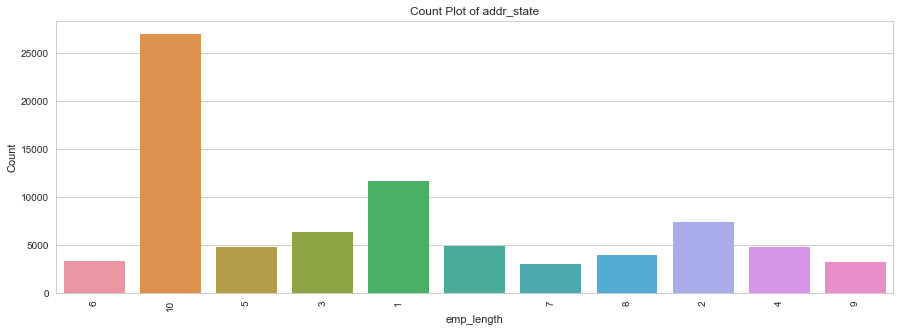

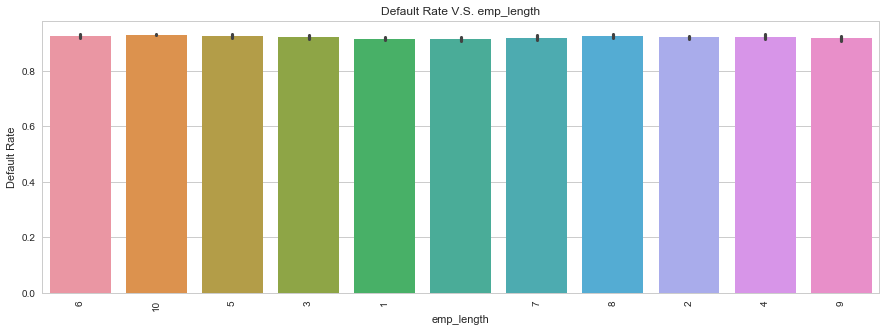

In [19]:
# Exploring on emp_length
plt.figure(figsize=(15,5))
sns.countplot(x="emp_length", data=data)
plt.xticks(rotation=90)
plt.title("Count Plot of addr_state")
plt.xlabel('emp_length')
plt.ylabel("Count")
plt.show()

# plot default_status V.S. addr_states
plt.figure(figsize=(15,5))
sns.barplot(x="emp_length", y="default_status", data=data)
plt.xticks(rotation=90)
plt.title('Default Rate V.S. emp_length')
plt.ylabel("Default Rate")
plt.show() 

In [20]:
A = data.groupby(['emp_length']).size()
B = pd.Series(A).values
print(B)

[ 4869 11629 26972  7309  6350  4748  4757  3299  3020  3869  3178]


In [21]:
C = data.groupby('emp_length').agg({'default_status':np.sum})
np.divide(C.default_status, B).sort_values()

emp_length
      0.914562
1     0.916674
9     0.917873
7     0.920861
2     0.921056
3     0.923307
4     0.924179
5     0.925373
6     0.926341
8     0.926596
10    0.931559
Name: default_status, dtype: float64

This output table shows the employment length and the corresponding non-default rate in an ascending order. 
So I divided it into 4 groups. The people with emp_length greater than 10 have outstanding non-default rate, so itself is a group.
8,6,5 are a group; 4,3,2,7 are another one, and 9,1,missing are the last group.
Then I used one-hot encoding, which I think can reduce the burden of tree, if I am going to use tree model. Since the emp_length now has 4 unique values, so I remove one redundant feature to get three dummy variables: emp_length2, emp_length3 ,emp_length4.


In [22]:
data.emp_length[data.emp_length.isin(['10'])] = 4

data.emp_length[data.emp_length.isin(['8','6','5'])] = 3
#     data['state'] = 2
data.emp_length[data.emp_length.isin(['4','3','2','7'])] = 2
#     data['state'] = 3
data.emp_length[data.emp_length.isin(['','1','9'])] = 1

C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value 

In [23]:
Y = pd.get_dummies(data['emp_length'])
del Y[1]
data = data.join(Y)
data.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m,default_status,2,3,4
0,88787390,30000,1,761.64,3,RENT,100100.0,Verified,Sep-2016,debt_consolidation,...,0,0,26.0,NaN,0,0.0,1,0,1,0
1,74722660,30000,1,692.93,4,MORTGAGE,235000.0,Source Verified,Apr-2016,home_improvement,...,0,1,16.0,NaN,1,3.0,1,0,0,1
2,67919555,16000,1,379.39,3,RENT,84000.0,Not Verified,Jan-2016,debt_consolidation,...,0,0,80.0,NaN,0,2.0,1,0,1,0
3,54027458,14000,0,439.88,3,RENT,50000.0,Source Verified,Jul-2015,debt_consolidation,...,0,0,NaN,42.0,0,NaN,1,0,1,0
4,72594974,7500,0,252.67,2,MORTGAGE,68000.0,Not Verified,Feb-2016,debt_consolidation,...,0,0,NaN,NaN,2,5.0,1,1,0,0


In [24]:
data.rename(columns={2:'emp_length2'},inplace=True)
data.rename(columns={3:'emp_length3'},inplace=True)
data.rename(columns={4:'emp_length4'},inplace=True)
data.drop('emp_length', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 28 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
home_ownership            80000 non-null object
annual_inc                80000 non-null float64
verification_status       80000 non-null object
issue_d                   80000 non-null object
purpose                   80000 non-null object
addr_state                80000 non-null object
dti                       80000 non-null float64
earliest_cr_line          80000 non-null object
fico_range_low            80000 non-null int64
fico_range_high           80000 non-null int64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            80000 non-null int64
delinq_amnt               800

<a id='section4.3'></a>

4.3 Exploration on Variable 'home_ownership'

The attribute home_ownership got four different values. So by the same reason, I used one hot encoding to replace this variable with three dummy variables: home_mortgage, home_own, home_rent.

C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


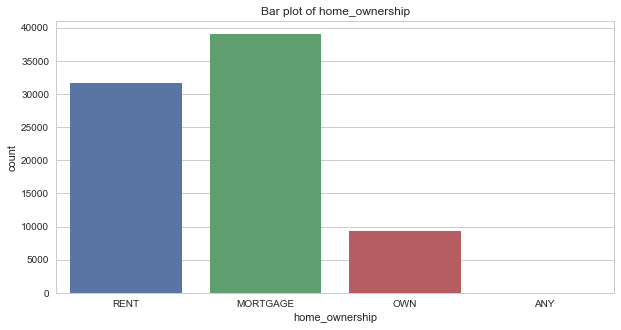

Source Verified    33189
Not Verified       23462
Verified           23349
Name: verification_status, dtype: int64

In [25]:
# variable "verification_status" is not binary, check its distribution
plt.figure(figsize=(10,5))
sns.countplot(x="home_ownership", data=data)
plt.title('Bar plot of home_ownership')
plt.show()
data.verification_status.value_counts()

In [26]:
Y = pd.get_dummies(data['home_ownership'])
del Y['ANY']
Y.head()
data = data.join(Y)
data.rename(columns={'MORTGAGE':'home_mortgage'},inplace=True)
data.rename(columns={'OWN':'home_own'},inplace=True)
data.rename(columns={'RENT':'home_rent'},inplace=True)
data.drop('home_ownership', axis=1, inplace=True)
data.info()
# data.drop('purpose', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 30 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
verification_status       80000 non-null object
issue_d                   80000 non-null object
purpose                   80000 non-null object
addr_state                80000 non-null object
dti                       80000 non-null float64
earliest_cr_line          80000 non-null object
fico_range_low            80000 non-null int64
fico_range_high           80000 non-null int64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               8000

<a id='section4.4'></a>

4.4 Exploration on variable 'verification_status'

For the verification_status, I used one hot encoding to replace this variable with two dummy variables: income_source_verified and income_verified.

C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


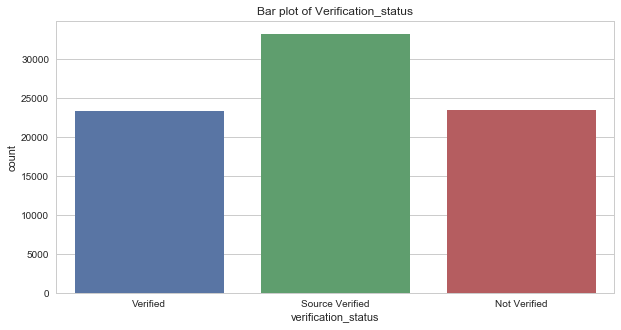

Source Verified    33189
Not Verified       23462
Verified           23349
Name: verification_status, dtype: int64

In [27]:
# variable "verification_status" is not binary, check its distribution
plt.figure(figsize=(10,5))
sns.countplot(x="verification_status", data=data)
plt.title('Bar plot of Verification_status')
plt.show()
data.verification_status.value_counts()

In [28]:
Z = pd.get_dummies(data['verification_status'])
del Z['Not Verified']
Z.head()
data = data.join(Z)
data.rename(columns={'Verified':'income_verified'},inplace=True)
data.rename(columns={'Source Verified':'income_source_verified'},inplace=True)
data.drop('verification_status', axis=1, inplace=True)
data.info()
# data.drop('purpose', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
issue_d                   80000 non-null object
purpose                   80000 non-null object
addr_state                80000 non-null object
dti                       80000 non-null float64
earliest_cr_line          80000 non-null object
fico_range_low            80000 non-null int64
fico_range_high           80000 non-null int64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    41786

<a id='section4.5'></a>

4.5 Exploration on the variable 'purpose'

For the attribute ‘purpose’, I also choose to one hot encode it. But this variable has 13 different category, if one-hot encoding everything, the matrix would get very sparse.
From the plot shows below, it is easy to see only the debt_consolidation and credit_card are outstanding.
The rest variables are only small part of the total count. 

C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


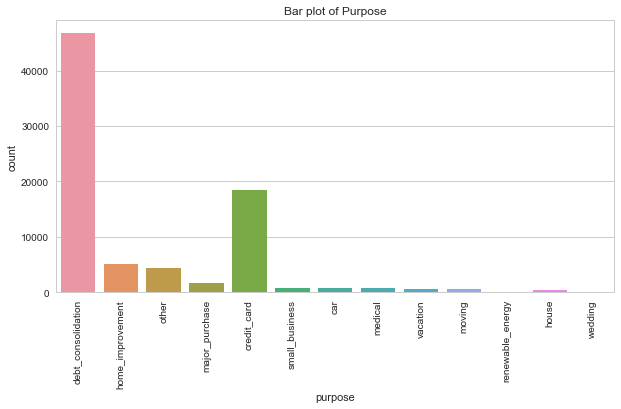

debt_consolidation    46721
credit_card           18469
home_improvement       5050
other                  4352
major_purchase         1647
medical                 832
car                     760
small_business          754
moving                  532
vacation                503
house                   328
renewable_energy         51
wedding                   1
Name: purpose, dtype: int64

In [29]:
# variable "purpose" is not binary, check its distribution
plt.figure(figsize=(10,5))
sns.countplot(x="purpose", data=data)
plt.title('Bar plot of Purpose')
plt.xticks(rotation=90)
plt.show()
data.purpose.value_counts()

So I first categorize the value into three group: debt_consolidation, credit_card and others. The group others is the sum of all the variables except the most two variables. Then one hot encode it to get two dummy variables: purpose_consolidation and purpose_creditcard.
The reason is no information loss as well as less likely overfitting.


In [30]:
X = pd.get_dummies(data['purpose'])
del X['renewable_energy'] 
del X['wedding'] 
del X['home_improvement']       
del X['other']                  
del X['major_purchase']         
del X['medical']                 
del X['car']                     
del X['small_business']          
del X['moving']                  
del X['vacation']                
del X['house']           
data = data.join(X)

data.rename(columns={'debt_consolidation':'purpose_consolidation '},inplace=True)
data.rename(columns={'credit_card':'purpose_creditcard'},inplace=True)
data.drop('purpose', axis=1, inplace=True)
data.head()

,id,loan_amnt,term,installment,annual_inc,issue_d,addr_state,dti,earliest_cr_line,fico_range_low,...,emp_length2,emp_length3,emp_length4,home_mortgage,home_own,home_rent,income_source_verified,income_verified,purpose_creditcard,purpose_consolidation
0,88787390,30000,1,761.64,100100.0,Sep-2016,SC,27.42,Jan-1976,690,...,0,1,0,0,0,1,0,1,0,1
1,74722660,30000,1,692.93,235000.0,Apr-2016,PA,7.50,Jan-1995,670,...,0,0,1,1,0,0,1,0,0,0
2,67919555,16000,1,379.39,84000.0,Jan-2016,FL,27.87,Aug-1998,735,...,0,1,0,0,0,1,0,0,0,1
3,54027458,14000,0,439.88,50000.0,Jul-2015,WV,21.65,Oct-1996,725,...,0,1,0,0,0,1,1,0,0,1
4,72594974,7500,0,252.67,68000.0,Feb-2016,OH,29.09,Nov-2000,660,...,1,0,0,1,0,0,0,0,0,1


<a id='section4.6'></a>

4.6 Exploration on the variable 'addr_state'

For this attribute, I cannot one hot encode it. Because it includes 50 states, if I get 49 dummy variables, it would be too sparse. 
And from the picture above although it seems that the default at the almost same level. But if we substract it from the mean value, it would be significant. 

C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


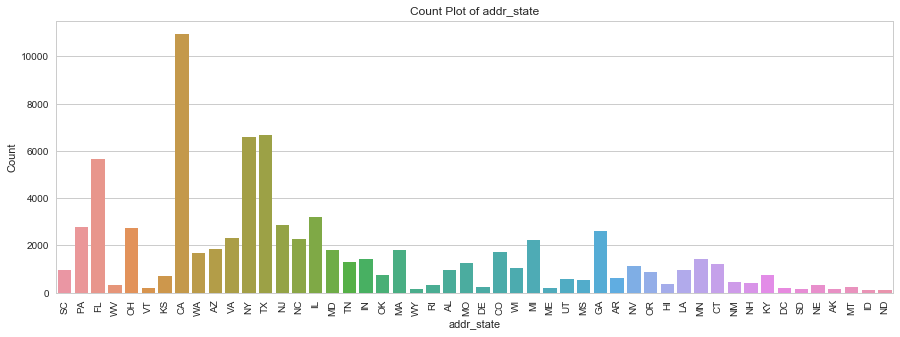

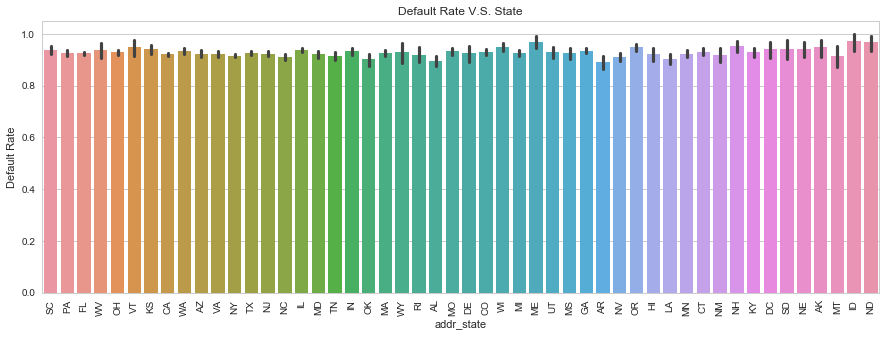

In [31]:
# Exploring on addr_state
plt.figure(figsize=(15,5))
sns.countplot(x="addr_state", data=data)
plt.xticks(rotation=90)
plt.title("Count Plot of addr_state")
plt.xlabel('addr_state')
plt.ylabel("Count")
plt.show()

# plot default_status V.S. addr_states
plt.figure(figsize=(15,5))
sns.barplot(x="addr_state", y="default_status", data=data)
plt.xticks(rotation=90)
plt.title('Default Rate V.S. State')
plt.ylabel("Default Rate")
plt.show()

# From the barplot, it is easy to see all the default rate to the addr_state is seem to be uniform
# the default_status would not be a relevant to location

In [32]:
A = data.groupby(['addr_state']).size()

B = pd.Series(A).values
print(B)

[  170   966   632  1862 10955  1705  1221   199   250  5661  2599   374
   108  3197  1404   701   737   940  1811  1813   196  2219  1419  1263
   518   219  2283   119   306   392  2872   441  1117  6574  2721   741
   858  2769   343   961   157  1297  6672   562  2316   177  1668  1023
   326   166]


In [33]:
C = data.groupby('addr_state').agg({'default_status':np.sum})
np.divide(C.default_status, B).sort_values()
#.sort_values(by=['default_status'], ascending=False)

addr_state
AR    0.889241
AL    0.894410
OK    0.901484
LA    0.902128
NC    0.910206
NV    0.911370
MT    0.913242
NY    0.915120
TN    0.915189
NM    0.916100
RI    0.918367
MD    0.920022
CA    0.920767
HI    0.922460
MN    0.922481
VA    0.923143
AZ    0.923201
NJ    0.923747
DE    0.924000
FL    0.924218
MS    0.924710
MA    0.924903
PA    0.925605
TX    0.926109
MI    0.926543
WY    0.927711
KY    0.928087
OH    0.928703
UT    0.928826
CO    0.929619
CT    0.931204
MO    0.932700
IN    0.933761
GA    0.934975
WA    0.935252
WV    0.935583
SC    0.936524
IL    0.937754
DC    0.939698
KS    0.940086
NE    0.941176
SD    0.942675
AK    0.947059
OR    0.947552
VT    0.949153
WI    0.949169
NH    0.951531
ND    0.966387
ME    0.969388
ID    0.972222
Name: default_status, dtype: float64

So I sort the default rate of 50 state in an ascending order, group them into 5 according to their default rate, then get four dummy variables: state_default2, state_default3, state_default4, state_default5. 

In [34]:
data.addr_state[data.addr_state.isin(['AR','AL','OK','LA','NC','NV','MT','NY','TN','NM'])] = 1

data.addr_state[data.addr_state.isin(['RI','MD','CA','HI','MN','VA','AZ','NJ','DE','FL'])] = 2
#     data['state'] = 2
data.addr_state[data.addr_state.isin(['MS','MA','PA','TX','MI','WY','KY','OH','UT','CO'])] = 3
#     data['state'] = 3
data.addr_state[data.addr_state.isin(['CT','MO','IN','GA','WA','WV','SC','IL','DC','KS'])] = 4

data.addr_state[data.addr_state.isin(['NE','SD','AK','OR','VT','WI','NH','ND','ME','ID'])] = 5

C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value 

In [35]:
Y = pd.get_dummies(data['addr_state'])
del Y[1]
data = data.join(Y)
data.head()

,id,loan_amnt,term,installment,annual_inc,issue_d,addr_state,dti,earliest_cr_line,fico_range_low,...,home_own,home_rent,income_source_verified,income_verified,purpose_creditcard,purpose_consolidation,2,3,4,5
0,88787390,30000,1,761.64,100100.0,Sep-2016,4,27.42,Jan-1976,690,...,0,1,0,1,0,1,0,0,1,0
1,74722660,30000,1,692.93,235000.0,Apr-2016,3,7.50,Jan-1995,670,...,0,0,1,0,0,0,0,1,0,0
2,67919555,16000,1,379.39,84000.0,Jan-2016,2,27.87,Aug-1998,735,...,0,1,0,0,0,1,1,0,0,0
3,54027458,14000,0,439.88,50000.0,Jul-2015,4,21.65,Oct-1996,725,...,0,1,1,0,0,1,0,0,1,0
4,72594974,7500,0,252.67,68000.0,Feb-2016,3,29.09,Nov-2000,660,...,0,0,0,0,0,1,0,1,0,0


In [36]:
data.rename(columns={2:'state_default2'},inplace=True)
data.rename(columns={3:'state_default3'},inplace=True)
data.rename(columns={4:'state_default4'},inplace=True)
data.rename(columns={5:'state_default5'},inplace=True)
data.drop('addr_state', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 35 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
issue_d                   80000 non-null object
dti                       80000 non-null float64
earliest_cr_line          80000 non-null object
fico_range_low            80000 non-null int64
fico_range_high           80000 non-null int64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    41786 non-null float64
mths_since_last_record    14532 non-null float64
inq_last_6mths            800

<a id='section4.7'></a>

4.7 Exploration on the Variable 'issue_time’ and ‘earliest_time'

Issue_time: The month which the loan was funded.
Earliest_time: The month the borrower's earliest reported credit line was opened.
These two variables cannot be directly used for analysis. So I use one to subtract another in order to get the variable time_length.


In [37]:
# issue_d : The month which the loan was funded
# earliest_cr_time : The month the borrower's earliest reported credit line was opened
import pandas as pd
import datetime
data['issue_time'] = pd.to_datetime(pd.Series(data['issue_d']))
data['earliest_time'] = pd.to_datetime(pd.Series(data['earliest_cr_line']))
data.head()

,id,loan_amnt,term,installment,annual_inc,issue_d,dti,earliest_cr_line,fico_range_low,fico_range_high,...,income_source_verified,income_verified,purpose_creditcard,purpose_consolidation,state_default2,state_default3,state_default4,state_default5,issue_time,earliest_time
0,88787390,30000,1,761.64,100100.0,Sep-2016,27.42,Jan-1976,690,694,...,0,1,0,1,0,0,1,0,2016-09-01,1976-01-01
1,74722660,30000,1,692.93,235000.0,Apr-2016,7.50,Jan-1995,670,674,...,1,0,0,0,0,1,0,0,2016-04-01,1995-01-01
2,67919555,16000,1,379.39,84000.0,Jan-2016,27.87,Aug-1998,735,739,...,0,0,0,1,1,0,0,0,2016-01-01,1998-08-01
3,54027458,14000,0,439.88,50000.0,Jul-2015,21.65,Oct-1996,725,729,...,1,0,0,1,0,0,1,0,2015-07-01,1996-10-01
4,72594974,7500,0,252.67,68000.0,Feb-2016,29.09,Nov-2000,660,664,...,0,0,0,1,0,1,0,0,2016-02-01,2000-11-01


In [38]:
data['time_length'] = ((pd.to_datetime(data.issue_time)-pd.to_datetime(data.earliest_time))/np.timedelta64(1, 'M')).astype(int)
data.drop('earliest_time', axis=1, inplace=True)
data.drop('issue_time', axis=1, inplace=True)
data.drop('issue_d', axis=1, inplace=True)
data.drop('earliest_cr_line', axis=1, inplace=True)
data.head()

,id,loan_amnt,term,installment,annual_inc,dti,fico_range_low,fico_range_high,last_credit_pull_d,last_fico_range_high,...,home_rent,income_source_verified,income_verified,purpose_creditcard,purpose_consolidation,state_default2,state_default3,state_default4,state_default5,time_length
0,88787390,30000,1,761.64,100100.0,27.42,690,694,Dec-2016,709,...,1,0,1,0,1,0,0,1,0,488
1,74722660,30000,1,692.93,235000.0,7.50,670,674,Dec-2016,649,...,0,1,0,0,0,0,1,0,0,254
2,67919555,16000,1,379.39,84000.0,27.87,735,739,Dec-2016,739,...,1,0,0,0,1,1,0,0,0,209
3,54027458,14000,0,439.88,50000.0,21.65,725,729,Oct-2016,749,...,1,1,0,0,1,0,0,1,0,224
4,72594974,7500,0,252.67,68000.0,29.09,660,664,Dec-2016,709,...,0,0,0,0,1,0,1,0,0,183


<a id='section4.8'></a>

4.8 Exploration on the Variable 'fico_range_high' and 'fico_range_low'

First of all, I want to point out the correlation between these two variables is 1, which means one variable can linearly predict another, one of them is redundant. 

In [39]:
b = data.loc[:, 'fico_range_low':'fico_range_high']
b.corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [40]:
# Since fico-range_low and fico_range_high are perfectly correlated
# I decide to calculate the mean of this two features to replace these two variables
data['fico_range_mean'] = (data['fico_range_low']+data['fico_range_high'])/2
data.head()
data.drop('fico_range_low', axis=1, inplace=True)
data.drop('fico_range_high', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 33 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
dti                       80000 non-null float64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    41786 non-null float64
mths_since_last_record    14532 non-null float64
inq_last_6mths            80000 non-null int64
inq_last_12m              37395 non-null float64
default_status            80000 non-null int64
emp_length2               80000 non-null uint8
emp_length3               800

So I decide to calculate the mean of these two as a new feature, which is called 'fico_range_mean'. And I did the same for the variables last_fico_range_high and last_fico_range_low.

<a id='section4.9'></a>

4.9 Exploration on the Variable 'mths_since_last_delinq'

This variable has around 40000 missing value, but I cannot delete it directly, because it seems to be an important predictor based on common sense and I don’t want to make a huge information loss.
I have three solutions:
1. use KNN model to cluster the records, then use the mean of the cluster to replace the missing value.
2. use mean value to fill the NaN, and then build another (0,1) binary feature as the index. With the row whose NaN was filled by mean, the corresponding value at the binary feature would be 0.
3. use EM algorithm to help fill the missing value.
As result, I decide to use the second method, and build an index feature named mths_delinq_index.

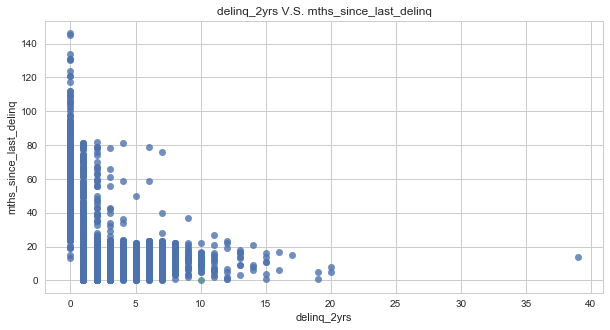

In [41]:
plt.figure(figsize=(10,5))
sns.regplot(x="delinq_2yrs", y="mths_since_last_delinq", data=data, ci=False, fit_reg=False)
plt.plot([10, 10], [1, 0], linewidth=3)
plt.title("delinq_2yrs V.S. mths_since_last_delinq")
plt.xlabel('delinq_2yrs')
plt.ylabel('mths_since_last_delinq')
plt.show()

In [42]:
mistake = data[data.delinq_2yrs == 0]
mistake = mistake[mistake.mths_since_last_delinq <= 24]
print(len(mistake.index))
data_copy = data.copy()

657


In [43]:
a = data.loc[:, 'delinq_2yrs':]
data.corr()

,id,loan_amnt,installment,annual_inc,dti,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,...,income_source_verified,income_verified,purpose_creditcard,purpose_consolidation,state_default2,state_default3,state_default4,state_default5,time_length,fico_range_mean
id,1.000000,-0.031509,-0.003708,0.010380,0.002643,0.106928,0.104093,-0.000396,0.007311,0.006003,...,-0.023652,0.015785,-0.025644,-0.035189,-0.003859,-0.001531,-0.006452,0.014550,-0.013627,0.030025
loan_amnt,-0.031509,1.000000,0.943747,0.263928,0.002063,0.126154,0.104300,-0.005468,-0.003668,-0.009736,...,0.007963,0.111102,0.041462,0.088949,0.007593,0.000633,0.012147,-0.015559,0.171966,0.119525
installment,-0.003708,0.943747,1.000000,0.253329,0.002407,0.095657,0.079708,-0.002143,-0.001603,-0.001645,...,0.003608,0.138785,0.023607,0.090495,0.013672,-0.003668,0.010545,-0.016074,0.144756,0.071918
annual_inc,0.010380,0.263928,0.253329,1.000000,-0.028039,0.038207,0.036506,0.008290,0.005893,0.026842,...,0.032614,-0.006343,0.002499,-0.022756,0.023120,-0.001301,0.001065,-0.024530,0.117488,0.064386
dti,0.002643,0.002063,0.002407,-0.028039,1.000000,-0.011154,-0.008435,0.000658,-0.000118,-0.002356,...,-0.015359,0.013654,0.003973,0.011011,-0.003216,0.001551,-0.001152,0.002698,0.008431,-0.011465
last_fico_range_high,0.106928,0.126154,0.095657,0.038207,-0.011154,1.000000,0.874206,-0.022669,-0.014415,-0.112578,...,-0.042820,-0.093790,0.080946,-0.025785,-0.005500,0.010238,0.004627,0.019669,0.113219,0.457631
last_fico_range_low,0.104093,0.104300,0.079708,0.036506,-0.008435,0.874206,1.000000,-0.019124,-0.010223,-0.080161,...,-0.033726,-0.074589,0.065981,-0.022229,-0.006914,0.008268,0.003878,0.018741,0.102650,0.355430
acc_now_delinq,-0.000396,-0.005468,-0.002143,0.008290,0.000658,-0.022669,-0.019124,1.000000,0.152779,0.134502,...,0.002917,0.009963,-0.005570,-0.003644,0.003497,-0.004111,-0.003892,0.003084,0.023118,-0.043846
delinq_amnt,0.007311,-0.003668,-0.001603,0.005893,-0.000118,-0.014415,-0.010223,0.152779,1.000000,0.024652,...,-0.003307,0.014252,-0.003450,0.001049,0.008478,-0.005658,-0.002490,0.004817,0.009621,-0.015118
delinq_2yrs,0.006003,-0.009736,-0.001645,0.026842,-0.002356,-0.112578,-0.080161,0.134502,0.024652,1.000000,...,0.009405,0.007082,-0.043821,0.017044,-0.013701,0.005579,0.006387,-0.002143,0.080678,-0.173207


delinq_2yrs: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 39}


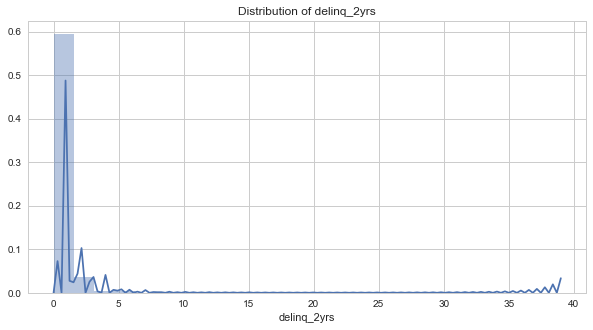

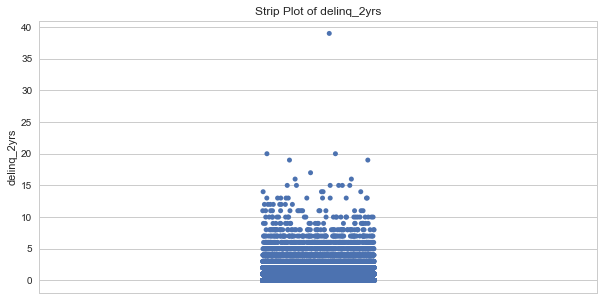

count    80000.000000
mean         0.352275
std          0.942411
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         39.000000
Name: delinq_2yrs, dtype: float64

In [44]:
# for the missing value mths_since_last_record, I choose to delete the variable
print(f"delinq_2yrs: {set(data.delinq_2yrs)}")
# check value distribution of variable "delinq_2yrs"
plt.figure(figsize=(10,5))
sns.distplot(data.delinq_2yrs, bins=25)
plt.title("Distribution of delinq_2yrs")
plt.xlabel('delinq_2yrs')
plt.show()
data.delinq_2yrs.describe()

# check value distribution of variable "delinq_2yrs" - stripplot
plt.figure(figsize=(10,5))
sns.stripplot(data = data, y = 'delinq_2yrs', jitter = True)
plt.title("Strip Plot of delinq_2yrs")
plt.ylabel("delinq_2yrs")
plt.xlabel("")

plt.show()

data.delinq_2yrs.describe()

In [45]:
data['mths_delinq_copy'] = data['mths_since_last_delinq']
data['mths_delinq_copy'].fillna(0, inplace=True)
data['mths_delinq_index'] = (data.mths_delinq_copy!=0).astype(int)

In [46]:
avg = data['mths_since_last_delinq'].mean()
print(avg)
data['mths_since_last_delinq'].fillna(33.9645575, inplace=True)

33.9645575072991


In [47]:
data.drop('mths_delinq_copy', axis=1, inplace=True)
data.loc[0:10,'mths_since_last_delinq':]

,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m,default_status,emp_length2,emp_length3,emp_length4,home_mortgage,home_own,...,income_verified,purpose_creditcard,purpose_consolidation,state_default2,state_default3,state_default4,state_default5,time_length,fico_range_mean,mths_delinq_index
0,26.000000,NaN,0,0.0,1,0,1,0,0,0,...,1,0,1,0,0,1,0,488,692.0,1
1,16.000000,NaN,1,3.0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,254,672.0,1
2,80.000000,NaN,0,2.0,1,0,1,0,0,0,...,0,0,1,1,0,0,0,209,737.0,1
3,33.964557,42.0,0,NaN,1,0,1,0,0,0,...,0,0,1,0,0,1,0,224,727.0,0
4,33.964557,NaN,2,5.0,1,1,0,0,1,0,...,0,0,1,0,1,0,0,183,662.0,0
5,14.000000,NaN,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,110,672.0,1
6,33.964557,NaN,1,3.0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,95,757.0,0
7,33.964557,NaN,0,NaN,1,0,1,0,0,0,...,0,0,1,0,0,1,0,55,732.0,0
8,33.964557,NaN,0,1.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,106,762.0,0
9,33.964557,NaN,0,0.0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,542,732.0,0


<a id='section4.10'></a>

4.10 Exploration on the Variable 'inq_last_12m'

This attribute has 42605 missing values. And based on the common sense, it has relationship with the variable inq_last_6m. Then I check for the correlation, it turns out to be 0.5 . It means these two variables have strong correlation. Took all the factor into account, I choose to delete this variable.

In [48]:
b = data.loc[:, 'inq_last_6mths':'inq_last_12m']
b.corr()

,inq_last_6mths,inq_last_12m
inq_last_6mths,1.00000,0.48946
inq_last_12m,0.48946,1.00000


In [49]:
data.drop('inq_last_12m', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 33 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
dti                       80000 non-null float64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    80000 non-null float64
mths_since_last_record    14532 non-null float64
inq_last_6mths            80000 non-null int64
default_status            80000 non-null int64
emp_length2               80000 non-null uint8
emp_length3               80000 non-null uint8
emp_length4               80000

<a id='section4.11'></a>

4.11 Miscellaneous


In [50]:
c = data.loc[:, 'last_fico_range_high':]
c.corr()
# By the same reason, replace last_fico_range_high and last_fico_range_low with last_fico_range_mean
data['last_fico_range_mean'] = (data['last_fico_range_low']+data['last_fico_range_high'])/2
data.head()
data.drop('last_fico_range_low', axis=1, inplace=True)
data.drop('last_fico_range_high', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 32 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
dti                       80000 non-null float64
last_credit_pull_d        79996 non-null object
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    80000 non-null float64
mths_since_last_record    14532 non-null float64
inq_last_6mths            80000 non-null int64
default_status            80000 non-null int64
emp_length2               80000 non-null uint8
emp_length3               80000 non-null uint8
emp_length4               80000 non-null uint8
home_mortgage             80000 non-null uint8
home_own                  80000

In [51]:
data.drop('last_credit_pull_d', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
dti                       80000 non-null float64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    80000 non-null float64
mths_since_last_record    14532 non-null float64
inq_last_6mths            80000 non-null int64
default_status            80000 non-null int64
emp_length2               80000 non-null uint8
emp_length3               80000 non-null uint8
emp_length4               80000 non-null uint8
home_mortgage             80000 non-null uint8
home_own                  80000 non-null uint8
home_rent                 80000 

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
dti                       80000 non-null float64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    80000 non-null float64
mths_since_last_record    14532 non-null float64
inq_last_6mths            80000 non-null int64
default_status            80000 non-null int64
emp_length2               80000 non-null uint8
emp_length3               80000 non-null uint8
emp_length4               80000 non-null uint8
home_mortgage             80000 non-null uint8
home_own                  80000 non-null uint8
home_rent                 80000 

In [53]:
data.drop('mths_since_last_record', axis=1, inplace=True)

In [54]:
data.head()

,id,loan_amnt,term,installment,annual_inc,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,...,purpose_creditcard,purpose_consolidation,state_default2,state_default3,state_default4,state_default5,time_length,fico_range_mean,mths_delinq_index,last_fico_range_mean
0,88787390,30000,1,761.64,100100.0,27.42,0,0,0,26.000000,...,0,1,0,0,1,0,488,692.0,1,707.0
1,74722660,30000,1,692.93,235000.0,7.50,0,0,1,16.000000,...,0,0,0,1,0,0,254,672.0,1,647.0
2,67919555,16000,1,379.39,84000.0,27.87,0,0,0,80.000000,...,0,1,1,0,0,0,209,737.0,1,737.0
3,54027458,14000,0,439.88,50000.0,21.65,0,0,0,33.964557,...,0,1,0,0,1,0,224,727.0,0,747.0
4,72594974,7500,0,252.67,68000.0,29.09,0,0,0,33.964557,...,0,1,0,1,0,0,183,662.0,0,707.0


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 30 columns):
id                        80000 non-null int64
loan_amnt                 80000 non-null int64
term                      80000 non-null category
installment               80000 non-null float64
annual_inc                80000 non-null float64
dti                       80000 non-null float64
acc_now_delinq            80000 non-null int64
delinq_amnt               80000 non-null int64
delinq_2yrs               80000 non-null int64
mths_since_last_delinq    80000 non-null float64
inq_last_6mths            80000 non-null int64
default_status            80000 non-null int64
emp_length2               80000 non-null uint8
emp_length3               80000 non-null uint8
emp_length4               80000 non-null uint8
home_mortgage             80000 non-null uint8
home_own                  80000 non-null uint8
home_rent                 80000 non-null uint8
income_source_verified    80000 no

In [901]:
data.to_csv('personal_load_data.csv', sep=',', encoding='utf-8')

<a id='section1'></a>

5.Model Building

I decide to try logistic regression, gradient boosting, random forest as well as fully connected neural network.
But the gradient boosting and random forest would be the best based on the accuracy, complexity, data preprocessing concern.
The reason I need to try the linear classifier like logistic regression is because I want to see if this dataset is linearly separable. However, the its performance is highly dependent on the imputation method we choose. So even if we get high accuracy by using logistic, we still need to try others. 
Gradient boosting is to fit the model on the residual left from the last tree in order to learn complex decision boundary. As the trees are getting more, we can get high accuracy. So for the dataset with many features, it would be a good choice. Also, it has an objective function to guide the model search, which is a great advantage over the other heuristic methods.
Compared with gradient boosting, random forest can build the tree parallel, which indicate it is faster than gradient boosting. But for this dataset, this advantage can be ignored. Also, it can reduce overfitting, because it is kind like bagging of decision trees.
For Neural Nets, if I can build 4 or 5 layers, I think it can also give pretty good result. But in this case, I do not think it can over power random forest and gradient boosting. Also, the time consuming is a big problem.

Since the company would pay more attention to the false positive rate. So I decide to use the AUC score as the measurement. It incorporates different aspects of the performance into a single number. Both sensitivity and specificity for all threshold levels are incorporated in the number given by AUC. 

<a id='section5.1'></a>

5.1 Logistic Regression

In [7]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [57]:
##preprocess the dataset and crossvalidate
x = data.drop("default_status", axis=1)
x = x.drop("id", axis=1)
y = data[["default_status"]].values.ravel()

#Split the dataset into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [154]:
# tune for hyperparameters
param_test1 = {'penalty':['l1','l2'], 'C':[0.01, 0.1, 1, 5, 10]}
gsearch_log1 = GridSearchCV(estimator = linear_model.LogisticRegression(class_weight='balanced'), param_grid = param_test1, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch_log1.fit(x_train,y_train)
gsearch_log1.grid_scores_, gsearch_log1.best_params_, gsearch_log1.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91894, std: 0.00491, params: {'C': 0.01, 'penalty': 'l1'},
  mean: 0.91810, std: 0.00643, params: {'C': 0.01, 'penalty': 'l2'},
  mean: 0.92539, std: 0.00450, params: {'C': 0.1, 'penalty': 'l1'},
  mean: 0.91901, std: 0.00580, params: {'C': 0.1, 'penalty': 'l2'},
  mean: 0.92550, std: 0.00449, params: {'C': 1, 'penalty': 'l1'},
  mean: 0.92054, std: 0.00520, params: {'C': 1, 'penalty': 'l2'},
  mean: 0.92552, std: 0.00448, params: {'C': 5, 'penalty': 'l1'},
  mean: 0.91885, std: 0.00247, params: {'C': 5, 'penalty': 'l2'},
  mean: 0.92551, std: 0.00449, params: {'C': 10, 'penalty': 'l1'},
  mean: 0.91925, std: 0.00621, params: {'C': 10, 'penalty': 'l2'}],
 {'C': 5, 'penalty': 'l1'},
 0.92552471577412232)

In [156]:
# Train logistic regression with data selection bias
# Calculate the weight from training set
logreg = linear_model.LogisticRegression(penalty='l1', class_weight='balanced', C=5, multi_class='ovr')
logreg.fit(x_train, y_train)
CV_score = cross_val_score(logreg, x_train, y_train, cv=10, scoring='roc_auc')
log_CVscore = CV_score.mean()
print(f' Cross validation scores: {CV_score}')
print(f' Average score: {log_CVscore}')

 Cross validation scores: [ 0.92039815  0.92499759  0.92887567  0.92524015  0.93216864  0.9103576
  0.92813107  0.91714892  0.93573871  0.93144464]
 Average score: 0.9254501152397309


In [168]:
logreg = linear_model.LogisticRegression(penalty='l1', class_weight='balanced', C=5, multi_class='ovr')
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
train_auc = auc(fpr, tpr)
print(train_auc)

0.924783661633


In [169]:
def error_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return (TP, FP, TN, FN)

In [170]:
error_measure(y_test, y_pred)

(13360, 200, 1005, 1435)

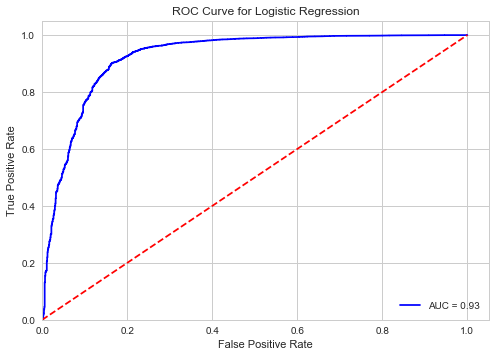

In [201]:
plt.title('ROC Curve for Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% train_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

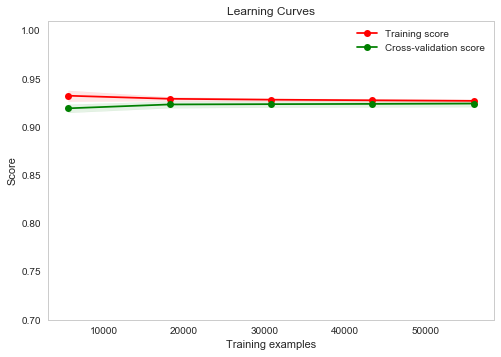

In [199]:
title = "Learning Curves"
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = linear_model.LogisticRegression(penalty='l1', class_weight='balanced', C=5, multi_class='ovr')
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

<a id='section5.2'></a>

5.2 Gradient Boosting

In [174]:
# Train a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# tune for n_estimator
param_test1 = {'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                                               min_samples_leaf=50, max_depth=7, max_features='sqrt',
                                                               subsample=0.8,random_state=10), param_grid = param_test1, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# accuracy_gb = []
# for i in [4, 6, 8, 10]:
#     model = GradientBoostingClassifier(learning_rate=0.1, max_depth=i)
#     model.fit(x_train, y_train)
#     # make predictions for test data
#     y_pred = model.predict(x_test)
#     predictions = [round(value) for value in y_pred]
#     # evaluate predictions
#     accuracy_gb = np.append(accuracy_gb, accuracy_score(y_test, predictions))
# print("Accuracy over testing set =", accuracy_gb)

# # Print out the accuracy of the classifier
# CM = confusion_matrix(y_test, y_pred)
# print("Accuracy of positive class:",CM[1,1]/(CM[1,0]+CM[1,1]))
# print("Accuracy of negative class:",CM[0,0]/(CM[0,0]+CM[0,1]))

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.90149, std: 0.00496, params: {'n_estimators': 10},
  mean: 0.91088, std: 0.00211, params: {'n_estimators': 20},
  mean: 0.91403, std: 0.00152, params: {'n_estimators': 30},
  mean: 0.91696, std: 0.00165, params: {'n_estimators': 40},
  mean: 0.91998, std: 0.00139, params: {'n_estimators': 50},
  mean: 0.92095, std: 0.00193, params: {'n_estimators': 60},
  mean: 0.92170, std: 0.00254, params: {'n_estimators': 70},
  mean: 0.92193, std: 0.00273, params: {'n_estimators': 80},
  mean: 0.92204, std: 0.00280, params: {'n_estimators': 90},
  mean: 0.92215, std: 0.00291, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 0.92214779470991926)

In [175]:
param_test2 = {'max_depth':[5,7,9,11], 'min_samples_split':[200, 400,600, 800]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt', 
                                                               subsample=0.8, min_samples_leaf=50, random_state=10), param_grid = param_test2, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(x_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92229, std: 0.00272, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.92257, std: 0.00323, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.92255, std: 0.00255, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.92233, std: 0.00333, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.92118, std: 0.00280, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.92189, std: 0.00297, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.92120, std: 0.00339, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.92137, std: 0.00368, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.91925, std: 0.00265, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.92038, std: 0.00231, params: {'max_depth': 9, 'min_samples_split': 400},
  mean: 0.92145, std: 0.00247, params: {'max_depth': 9, 'min_samples_split': 600},
  mean: 0.92075, std: 0.00315, params: {'max_depth': 9, 'min_samples_split': 800},
  me

In [177]:
param_test2 = {'max_depth':[3,4,5,6], 'min_samples_split':[300,400,500,600]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt', 
                                                               subsample=0.8, min_samples_leaf=50, random_state=10), param_grid = param_test2, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(x_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92023, std: 0.00247, params: {'max_depth': 3, 'min_samples_split': 300},
  mean: 0.91956, std: 0.00242, params: {'max_depth': 3, 'min_samples_split': 400},
  mean: 0.91886, std: 0.00293, params: {'max_depth': 3, 'min_samples_split': 500},
  mean: 0.91960, std: 0.00248, params: {'max_depth': 3, 'min_samples_split': 600},
  mean: 0.92128, std: 0.00336, params: {'max_depth': 4, 'min_samples_split': 300},
  mean: 0.92078, std: 0.00366, params: {'max_depth': 4, 'min_samples_split': 400},
  mean: 0.92093, std: 0.00366, params: {'max_depth': 4, 'min_samples_split': 500},
  mean: 0.92065, std: 0.00344, params: {'max_depth': 4, 'min_samples_split': 600},
  mean: 0.92275, std: 0.00309, params: {'max_depth': 5, 'min_samples_split': 300},
  mean: 0.92257, std: 0.00323, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.92295, std: 0.00320, params: {'max_depth': 5, 'min_samples_split': 500},
  mean: 0.92255, std: 0.00255, params: {'max_depth': 5, 'min_samples_split': 600},
  me

In [178]:
param_test3 = {'min_samples_split':[100,300,500,700], 'min_samples_leaf':[30,40,50,60,70]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92186, std: 0.00369, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: 0.92281, std: 0.00350, params: {'min_samples_leaf': 30, 'min_samples_split': 300},
  mean: 0.92242, std: 0.00290, params: {'min_samples_leaf': 30, 'min_samples_split': 500},
  mean: 0.92211, std: 0.00286, params: {'min_samples_leaf': 30, 'min_samples_split': 700},
  mean: 0.92222, std: 0.00293, params: {'min_samples_leaf': 40, 'min_samples_split': 100},
  mean: 0.92242, std: 0.00341, params: {'min_samples_leaf': 40, 'min_samples_split': 300},
  mean: 0.92329, std: 0.00242, params: {'min_samples_leaf': 40, 'min_samples_split': 500},
  mean: 0.92203, std: 0.00385, params: {'min_samples_leaf': 40, 'min_samples_split': 700},
  mean: 0.92185, std: 0.00329, params: {'min_samples_leaf': 50, 'min_samples_split': 100},
  mean: 0.92275, std: 0.00309, params: {'min_samples_leaf': 50, 'min_samples_split': 300},
  mean: 0.92295, std: 0.00320, params: {'min_samples_leaf': 50, 'min_samples_split': 500},

In [181]:
param_test4 = {'max_features':[8,10,12]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, 
                                                               min_samples_split=500, min_samples_leaf=40, subsample=0.8, 
                                                               random_state=10),param_grid = param_test4, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92331, std: 0.00344, params: {'max_features': 8},
  mean: 0.92413, std: 0.00310, params: {'max_features': 10},
  mean: 0.92343, std: 0.00297, params: {'max_features': 12}],
 {'max_features': 10},
 0.92412968874067791)

In [182]:
param_test5 = {'subsample':[0.7,0.75,0.8,0.85,0.9,1]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                                                               min_samples_split=500, min_samples_leaf=40, 
                                                               random_state=10, max_features=10,),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(x_train,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92423, std: 0.00271, params: {'subsample': 0.7},
  mean: 0.92394, std: 0.00306, params: {'subsample': 0.75},
  mean: 0.92413, std: 0.00310, params: {'subsample': 0.8},
  mean: 0.92402, std: 0.00300, params: {'subsample': 0.85},
  mean: 0.92424, std: 0.00314, params: {'subsample': 0.9},
  mean: 0.92391, std: 0.00304, params: {'subsample': 1}],
 {'subsample': 0.9},
 0.92423790733851552)

In [184]:
gbm_tuned_1 = GradientBoostingClassifier(loss = 'deviance',learning_rate=0.01, n_estimators=1000, max_depth=5, 
                                         min_samples_split=500, min_samples_leaf=40, subsample=0.9, 
                                         random_state=10, max_features=10)

cv_score = cross_val_score(gbm_tuned_1, x_train, y_train, cv=10, scoring='roc_auc')
print(cv_score)
print(cv_score.mean())

[ 0.91918893  0.92711504  0.92722237  0.92178238  0.93020077  0.91509323
  0.93068224  0.91827387  0.93618387  0.92728286]
0.925302553993


In [192]:
gbm_tuned_2 = GradientBoostingClassifier(loss = 'deviance',learning_rate=0.01, n_estimators=600, max_depth=5, 
                                         min_samples_split=500, min_samples_leaf=40, subsample=0.9, 
                                         random_state=10, max_features=10)

cv_score = cross_val_score(gbm_tuned_2, x_train, y_train, cv=10, scoring='roc_auc')
print(cv_score)
print(cv_score.mean())

[ 0.91924515  0.92751974  0.92757122  0.92145802  0.93044185  0.91593265
  0.93070778  0.91827247  0.93578281  0.92706483]
0.925399651968


In [194]:
model = GradientBoostingClassifier(loss = 'deviance',learning_rate=0.01, n_estimators=600, max_depth=5, 
                                         min_samples_split=500, min_samples_leaf=40, subsample=0.9, 
                                         random_state=10, max_features=10)
model.fit(x_train, y_train)
# make predictions for test data
y_pred = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
train_auc = auc(fpr, tpr)
print(train_auc)

0.925947787115


In [195]:
error_measure(y_test, y_pred)

(14569, 499, 706, 226)

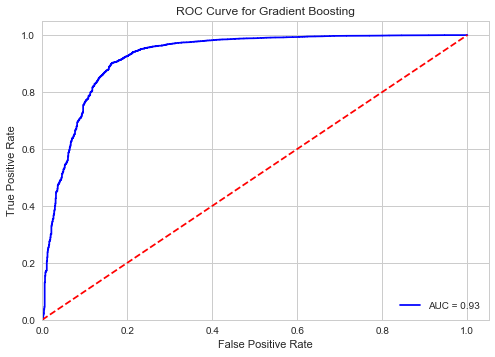

In [200]:
plt.title('ROC Curve for Gradient Boosting')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% train_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

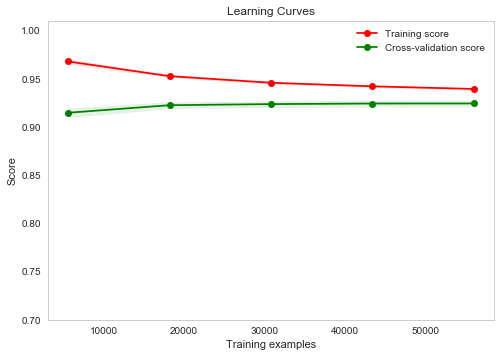

In [198]:
title = "Learning Curves"
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = GradientBoostingClassifier(loss = 'deviance',learning_rate=0.01, n_estimators=600, max_depth=5, 
                                         min_samples_split=500, min_samples_leaf=40, subsample=0.9, 
                                         random_state=10, max_features=10)
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

<a id='section5.3'></a>

5.3 Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

# tune for hyperparameters
param_test1 = {"n_estimators": [400,500],
              "max_depth": [12,14]}
gsearch_rf1 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test1, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch_rf1.fit(x_train,y_train)
gsearch_rf1.grid_scores_, gsearch_rf1.best_params_, gsearch_rf1.best_score_

# model = RandomForestClassifier(max_depth=12, max_features=6)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy_rf = np.append(accuracy_rf, accuracy_score(y_test, predictions))
# print("Accuracy over testing set =", accuracy_rf)
# # Print out the accuracy of the classifier
# CM = confusion_matrix(y_test, y_pred)
# print("Accuracy of positive class:",CM[1,1]/(CM[1,0]+CM[1,1]))
# print("Accuracy of negative class:",CM[0,0]/(CM[0,0]+CM[0,1]))

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91787, std: 0.00245, params: {'max_depth': 12, 'n_estimators': 400},
  mean: 0.91792, std: 0.00204, params: {'max_depth': 12, 'n_estimators': 500},
  mean: 0.91790, std: 0.00150, params: {'max_depth': 14, 'n_estimators': 400},
  mean: 0.91713, std: 0.00130, params: {'max_depth': 14, 'n_estimators': 500}],
 {'max_depth': 12, 'n_estimators': 500},
 0.91792312020744138)

In [213]:
# tune for hyperparameters
param_test1 = {"n_estimators": [400],
              "max_depth": [8],
              "max_features":[8,10]}
gsearch_rf1 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test1, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch_rf1.fit(x_train,y_train)
gsearch_rf1.grid_scores_, gsearch_rf1.best_params_, gsearch_rf1.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92001, std: 0.00328, params: {'max_depth': 14, 'max_features': 8, 'n_estimators': 400},
  mean: 0.92090, std: 0.00205, params: {'max_depth': 14, 'max_features': 10, 'n_estimators': 400}],
 {'max_depth': 14, 'max_features': 10, 'n_estimators': 400},
 0.9209022782984968)

In [60]:
# tune for hyperparameters
param_test2 = {"n_estimators": [400],
              "max_depth": [6,8,10],
              "max_features":[12,14]}
gsearch_rf2 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test2, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch_rf2.fit(x_train,y_train)
gsearch_rf2.grid_scores_, gsearch_rf2.best_params_, gsearch_rf2.best_score_

C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.92174, std: 0.00165, params: {'max_depth': 14, 'max_features': 12, 'n_estimators': 400},
  mean: 0.92123, std: 0.00170, params: {'max_depth': 14, 'max_features': 14, 'n_estimators': 400}],
 {'max_depth': 14, 'max_features': 12, 'n_estimators': 400},
 0.92174338091529395)

In [79]:
rf_tuned_1 = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=12)

cv_score = cross_val_score(rf_tuned_1, x_train, y_train, cv=10, scoring='roc_auc')
print(cv_score)
print(cv_score.mean())

[ 0.90999482  0.93581882  0.93400958  0.90676351  0.93081424  0.92226195
  0.93007436  0.9208497   0.92996908  0.92166378]
0.924221984261


In [64]:
model = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=12)
model.fit(x_train, y_train)
# make predictions for test data
y_pred = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
train_auc = auc(fpr, tpr)
print(train_auc)

0.919043331732


In [65]:
def error_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return (TP, FP, TN, FN)

In [66]:
error_measure(y_test, y_pred)

(14624, 523, 658, 195)

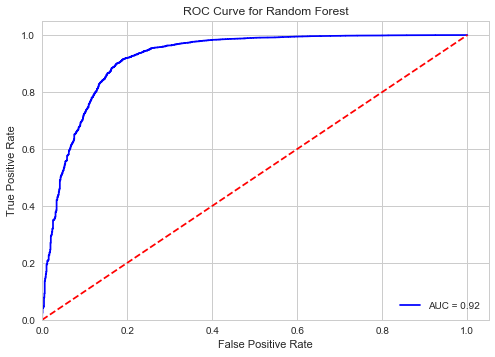

In [73]:
from sklearn.metrics import roc_curve, auc
model = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=12)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ROC Curve for Random Forest')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


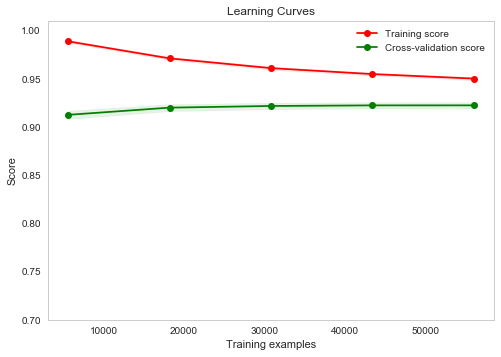

In [71]:
title = "Learning Curves"
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=12)
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

C:\Users\Joey\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


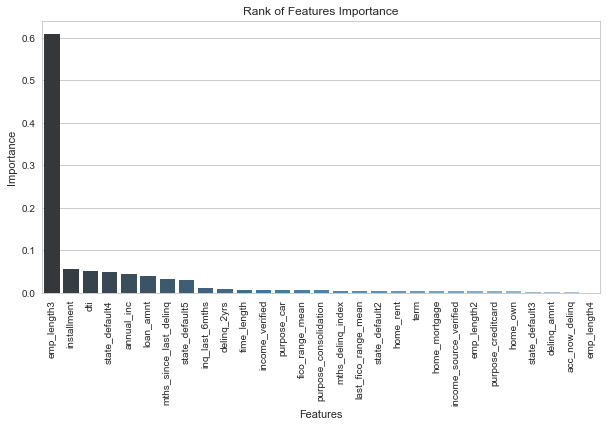

In [69]:
# features importance from random forest model
features_name = ['loan_amnt','term','installment','annual_inc','dti','acc_now_delinq','delinq_amnt','delinq_2yrs','mths_since_last_delinq',  
'inq_last_6mths','purpose_car','purpose_creditcard','purpose_consolidation','home_mortgage','home_own','home_rent','fico_range_mean',      
'last_fico_range_mean','income_source_verified','income_verified','time_length','mths_delinq_index','state_default2','state_default3',        
'state_default4','state_default5','emp_length2','emp_length3','emp_length4']
features_importance = pd.DataFrame([features_name, list(model.feature_importances_)], index=['Feature', 'Importance']).T
features_importance = features_importance.sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Feature", y="Importance", data=features_importance, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Rank of Features Importance")
plt.xlabel('Features')
plt.ylabel("Importance")
plt.show()

<a id='section6'></a>

6.Hypothesis Testing and Conclusion

In [83]:
from scipy import stats

[  5.05008298   5.25120648   3.19794299  22.83035567   0.97370202]


I am trying to use hypothesis testing on the three models to decide the best one. Since I am doing multiple hypothesis, so I implement Bonferroni Correction. So the alpha value woould be 0.05/2, which is 0.025.

In [90]:
Logistics = [0.92039815, 0.92499759, 0.92887567, 0.92524015, 0.93216864, 
             0.9103576, 0.92813107, 0.91714892, 0.93573871, 0.93144464]
GradientBoosting = [0.91924515, 0.92751974, 0.92757122, 0.92145802, 0.93044185, 
                    0.91593265, 0.93070778, 0.91827247, 0.9357828, 0.92706483]
from scipy import stats
stats.ttest_rel(Logistics, GradientBoosting)

Ttest_relResult(statistic=0.051980837842650222, pvalue=0.95967941512330346)

Since the p_value is greater than 0.025, the null hypothesis cannot be rejected, which means these two model have almost same performance on the existing dataset. 

In [89]:
RandomForest = [0.90999482, 0.93581882, 0.93400958, 0.90676351, 0.93081424, 0.92226195,
                0.93007436,  0.9208497, 0.92996908,  0.92166378]
GradientBoosting = [0.91924515, 0.92751974, 0.92757122, 0.92145802, 0.93044185, 
                    0.91593265, 0.93070778, 0.91827247, 0.9357828, 0.92706483]
from scipy import stats
stats.ttest_rel(RandomForest, GradientBoosting)

Ttest_relResult(statistic=-0.49560996545177266, pvalue=0.63204561219814437)

In [92]:
RandomForest = [0.90999482, 0.93581882, 0.93400958, 0.90676351, 0.93081424, 0.92226195,
                0.93007436,  0.9208497, 0.92996908,  0.92166378]
Logistics = [0.92039815, 0.92499759, 0.92887567, 0.92524015, 0.93216864, 
             0.9103576, 0.92813107, 0.91714892, 0.93573871, 0.93144464]
from scipy import stats
stats.ttest_rel(RandomForest, Logistics)

Ttest_relResult(statistic=-0.39547143691618336, pvalue=0.7017053408213807)

Since the p_value is greater than 0.025, the null hypothesis cannot be rejected, which means these two model have almost same performance on the existing dataset. 
So based on the hypothesis testing, all these models have good performance. And take learning curve into account, in Logistic Regression, training score (red line) decreases and plateau, which indicates underfitting issue.Also , the cross-validation score (green line) stagnating throughout, it means the model unable to learn from data as data increasing.
Comparing random forest and gradient boosting model, the gap of Gradient Boosting is smaller, which means less overfitting issue.
In conclusion, Graident boosting is the best model to be chosen.

<a id='section7'></a>

7.Future work

Because of the time constraint, I did not tune the model parameter to be best. It also affects the data imputation method I choose.
Also the feature could be better designed.
In the future, I would like to use EM algorithm and KNN to fill up the missing data, and put them in the model.
